
<h3> Welcome to the YOLOv11 Drowsiness Detection Notebook.</h3>
<br>
In this notebook, I finetune the Ultralytics <a href="https://github.com/ultralytics/ultralytics">YOLOv11</a> for drowsiness detection.

YOLOv11 is the latest version of the YOLO (You Only Look Once) AI models developed by Ultralytics.

YOLO11 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs.


This notebook shows the process of training and testing the drowsiness model.
</div>

# Setup
To make it easier to manage datasets, images and models, we create a HOME constant

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/workspace



Pip install ultralytics, pytorch and other dependencies

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.32 🚀 Python-3.11.10 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10002MiB)
Setup complete ✅ (16 CPUs, 15.5 GB RAM, 0.6/20.0 GB disk)


In [3]:
import torch

DEVICE = "cpu"

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  DEVICE = torch.cuda.current_device()


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3080


In [4]:
%pip install opencv-python matplotlib numpy pyyaml pillow requests pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1. Download model

Download the YOLO11 model


In [5]:
from ultralytics import YOLO
# 'yolov11s.pt' is the small version of YOLOv11
model = YOLO("yolo11s.pt")
print(model)

100%|██████████| 18.4M/18.4M [00:00<00:00, 61.8MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

Test the YOLO11 model by performing a prediction

In [6]:
# Run inference with YOLO
results = model.predict(source="https://ultralytics.com/images/zidane.jpg", save=True)

# get the data of the first inference prediction
print(results[0].orig_shape)
output_image = results[0].orig_img
output_image_dir = results[0].save_dir
input_image_path = results[0].path
print(output_image_dir)
print(input_image_path)

100%|██████████| 49.2k/49.2k [00:00<00:00, 9.06MB/s]


image 1/1 /workspace/zidane.jpg: 384x640 2 persons, 2 ties, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 58.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
(720, 1280)
runs/detect/predict
/workspace/zidane.jpg


Display the image prediction

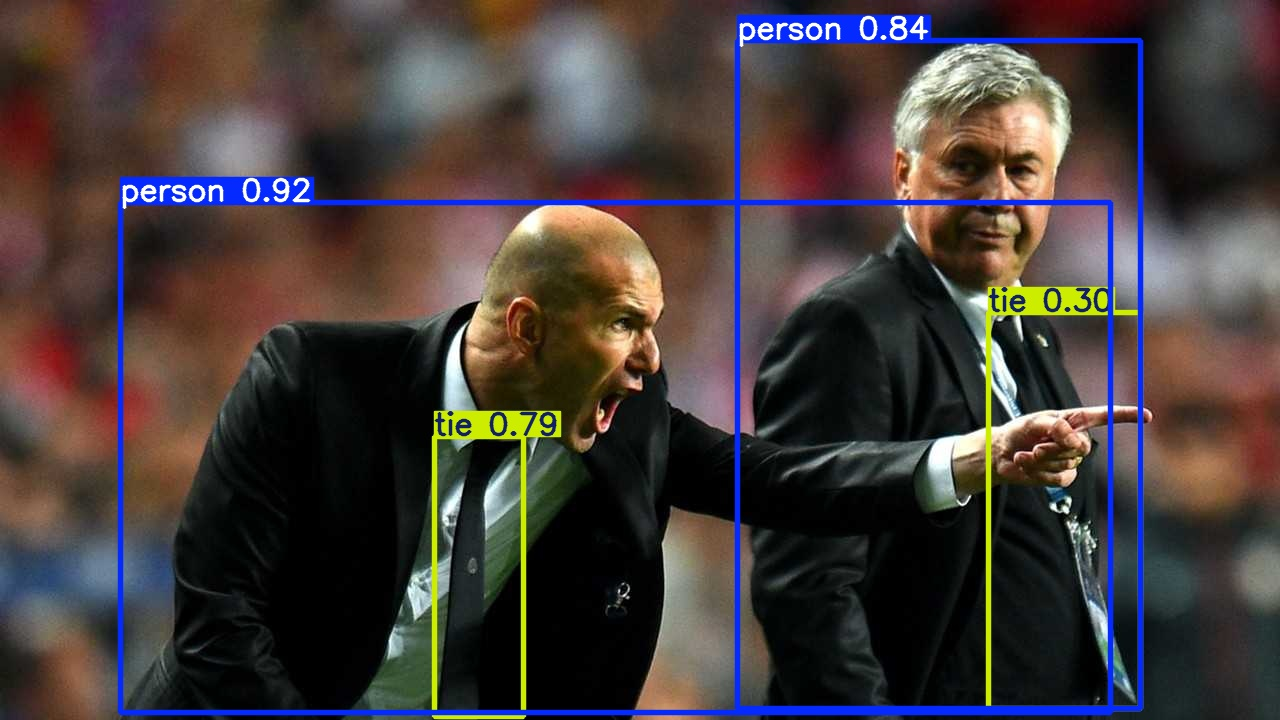

In [7]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=f'{HOME}/{output_image_dir}/{os.path.basename(input_image_path)}', width=600)

# 2. Dataset Loading
Download and prepare my cleaned images dataset for yolo


In [8]:

import requests

dataset_url = 'https://firebasestorage.googleapis.com/v0/b/electora-8c1d6.appspot.com/o/Complete YOLO Drowsy Images Dataset.zip?alt=media'
dataset_filename = 'dataset.zip'

print(f'Downloading my custom dataset ....')

# Send a GET request to fetch the file
response = requests.get(dataset_url)

# Ensure the request was successful (status code 200)
if response.status_code == 200:
    with open(dataset_filename, 'wb') as f:
        f.write(response.content)
    print(f'Dataset downloaded as {dataset_filename}')
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")



Dataset downloaded as dataset.zip


Unzip the dataset into the specified directory

In [9]:
import zipfile
import os

with zipfile.ZipFile(dataset_filename, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())
print(f'Dataset extracted to {os.getcwd()}')

Dataset extracted to /workspace


Verify the structure of the extracted files (this helps in understanding where train/val data is)

In [10]:
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'Complete YOLO Drowsy Images Dataset')):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace/Complete YOLO Drowsy Images Dataset with 2 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/train with 0 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/train/images with 13946 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/train/labels with 13946 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/val with 0 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/val/images with 734 files
Found folder: /workspace/Complete YOLO Drowsy Images Dataset/val/labels with 734 files


Display a grid of image samples from the dataset with data annotation

In [11]:
image_url = 'https://firebasestorage.googleapis.com/v0/b/electora-8c1d6.appspot.com/o/complete-yolo-dataset.jpg?alt=media'

IPyImage(url=image_url, width=600)

Cleanup the dataset zip file

In [12]:
!rm dataset.zip

# 3. Configure YAML file and Setup Persistent Storage
Set up and start the YOLO training(finetuning) using the custom YAML file and dataset

In [13]:
import yaml

# Define paths for train and val directories
train_dir = os.path.join(os.getcwd(),'Complete YOLO Drowsy Images Dataset', 'train')
val_dir = os.path.join(os.getcwd(), 'Complete YOLO Drowsy Images Dataset', 'val')

# Define the classes for the dataset
class_names = ["Awake", "Drowsy"]

# Create the custom YAML file (dataset_custom.yaml)
yaml_content = {
    'train': train_dir,
    'val': val_dir,
    'nc': len(class_names),
    'names': class_names
}

yaml_file = 'dataset_custom.yaml'
with open(yaml_file, 'w') as yaml_out:
    yaml.dump(yaml_content, yaml_out, default_flow_style=False)
print(f'Custom YAML file created: {yaml_file}')

Custom YAML file created: dataset_custom.yaml


#Setup Persistent Storage
Setup cloud storage for saving and loading the project files between training checkpoints.

In [14]:
import requests
import zipfile
import os

def backup_model_files():
  try:
    directory_path = os.path.join(HOME, "my_yolo_train")
    # Create a ZipFile object in write mode
    with zipfile.ZipFile("my_yolo_train.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory and add all files to the zip
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Add the file to the zip file, maintaining the directory structure
                zipf.write(file_path, os.path.relpath(file_path, directory_path))
    print(f"Directory '{directory_path}' has been zipped and saved as my_yolo_train.zip")
    file_path=os.path.join(HOME, "my_yolo_train.zip")
    # Upload the zipped file
    with open(file_path, "rb") as f:
        file_data = f.read()
    cloud_storage_path ="my_yolo_train.zip"
    url = f"https://firebasestorage.googleapis.com/v0/b/electora-8c1d6.appspot.com/o/{cloud_storage_path}"
    response = requests.post(url, data=file_data)
    if response.status_code == 200:
        print("File uploaded successfully:", response.json())
    else:
        print("Failed to upload file:", response.text)
  except Exception as e:
    print(f"Failed to backup the file: {e}")

def download_model_files():
  try:
    directory_path = os.path.join(HOME, "my_yolo_train")
    cloud_storage_path ="my_yolo_train.zip"
    url = f"https://firebasestorage.googleapis.com/v0/b/electora-8c1d6.appspot.com/o/{cloud_storage_path}?alt=media"
    response = requests.get(url) # Send a GET request to fetch the file
    if response.status_code == 200:
        file_path=os.path.join(HOME, "my_yolo_train.zip")
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f'File downloaded as {file_path}')
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
          zip_ref.extractall(directory_path)
          print(f'File extracted to {directory_path}')
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
  except Exception as e:
    print(f"Failed to download the file: {e}")



# 4. Train
model.train is used for training a YOLO11 model on a custom dataset. In this mode, the model is trained using the specified dataset and hyperparameters. The training process involves optimizing the model's parameters so that it can accurately predict the classes and locations of objects in an image.

In [ ]:
download_model_files()

last_trained_model_path = f'{HOME}/my_yolo_train/drowsy_detection/weights/last.pt'

if os.path.exists(last_trained_model_path):
    model = YOLO(f"{HOME}/my_yolo_train/drowsy_detection/weights/last.pt")  # load my partially trained model
    results = model.train(resume=True, epochs=100)
else:
    # Train the YOLO model with the custom dataset
    results = model.train(data=yaml_file, epochs=50, imgsz=640, batch=16, val=True, project='my_yolo_train', name='drowsy_detection', save=True,
                          device=DEVICE, cache=True, plots=True, exist_ok=True)

backup_model_files()

File downloaded as /workspace/my_yolo_train.zip
File extracted to /workspace
Ultralytics 8.3.32 🚀 Python-3.11.10 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10002MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=dataset_custom.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=my_yolo_train, name=drowsy_detection, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

100%|██████████| 755k/755k [00:00<00:00, 15.7MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

YOLO11s summary: 319 layers, 9,428,566 parameters, 9,428,550 gradients, 21.6 GFLOPs

Transferred 88/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 56.9MB/s]


AMP: checks passed ✅


train: Scanning /workspace/Complete YOLO Drowsy Images Dataset/train/labels... 13946 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13946/13946 [00:02<00:00, 5121.97it/s]


train: New cache created: /workspace/Complete YOLO Drowsy Images Dataset/train/labels.cache
train: 18.0GB RAM required to cache images with 50% safety margin but only 12.0/15.5GB available, not caching images ⚠️


val: Scanning /workspace/Complete YOLO Drowsy Images Dataset/val/labels... 734 images, 0 backgrounds, 0 corrupt: 100%|██████████| 734/734 [00:00<00:00, 2914.35it/s]

val: New cache created: /workspace/Complete YOLO Drowsy Images Dataset/val/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.6GB RAM): 100%|██████████| 734/734 [00:00<00:00, 2719.53it/s]


Plotting labels to my_yolo_train/drowsy_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to my_yolo_train/drowsy_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.23G      2.835      3.887      2.905         31        640:  20%|██        | 175/872 [00:18<01:12,  9.55it/s]

Training Results Table

In [ ]:
import pandas as pd

# Path to the CSV file
file_path = f'{HOME}/my_yolo_train/drowsy_detection/results.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

df


#5. Training Visualizations

List of all the plots that are useful for visualizing the training process.

In [ ]:
!ls {HOME}/my_yolo_train/drowsy_detection/

The confusion matrix plot

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/my_yolo_train/drowsy_detection/confusion_matrix.png', width=600)

training and validation loss graphs

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/my_yolo_train/drowsy_detection/results.png', width=600)

#6. Model Validation

model.val mode is used for validating a YOLO11 model after it has been trained. In this mode, the model is evaluated on a validation set to measure its accuracy and generalization performance. This mode can be used to tune the hyperparameters of the model to improve its performance.

Model Validation - Dataset Batch 0 (Predictions and Labels)




In [ ]:
print("Validation Labels: ")
IPyImage(filename=f'{HOME}/my_yolo_train/drowsy_detection/val_batch0_labels.jpg', width=600)

In [ ]:
print("Validation Predictions: ")
IPyImage(filename=f'{HOME}/my_yolo_train/drowsy_detection/val_batch0_pred.jpg', width=600)

start model validation

In [ ]:

# Evaluate the model's performance on the validation set
last_trained_model_path = f'{HOME}/my_yolo_train/drowsy_detection/weights/last.pt'

if os.path.exists(last_trained_model_path):
    model = YOLO(f"{HOME}/my_yolo_train/drowsy_detection/weights/last.pt")  # load my partially trained model
    results = model.val(data=yaml_file, save_json=True, plots=True)
else:
  results = model.val(data=yaml_file, save_json=True, plots=True)

#Predict
Here, predictions are made using the finetuned YOLO11 model on new a image.

In [ ]:
# Run inference with YOLO
results = model.predict(source="https://www.sleepfoundation.org/wp-content/uploads/2023/11/drowsy-driver-1024x683.jpg", save=True)

# get the data of the first inference prediction
print(results[0].orig_shape)
output_image = results[0].orig_img
output_image_dir = results[0].save_dir
input_image_path = results[0].path
print(output_image_dir)
print(input_image_path)
print(results)

In [ ]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=f'{HOME}/{output_image_dir}/{os.path.basename(input_image_path)}', width=600)

# Export Model

ONNX(Open Neural Network Exchange) models are often deployed on CPUs due to their compatibility with ONNX Runtime. This runtime is optimized for CPU execution and significantly improves CPU inference speed, up to about 3x CPU speedup.

Dynamic input size allows the exported model to handle varying image dimensions, providing flexibility and optimizing processing efficiency for different use cases. When exporting to formats like ONNX or TensorRT, enabling dynamic input size ensures that the model can adapt to different input shapes seamlessly.

In [ ]:
# Export the model to ONNX format
model.export(format="onnx", dynamic=True)